# HALHF Particle Transverse Wake Instability Full Length Half Gradient First Stage

For simulating the HALHF linac with interstages. The simulation employs the particle transverse wake instability model.

Ben Chen, 10 November 2023, University of Oslo

## Import ABEL framework and required classes

In [1]:
import sys
sys.path.append('../')
from abel import *
import numpy as np

from scipy.constants import c, e, m_e, epsilon_0 as eps0
from abel.utilities.relativity import energy2gamma

# Enable the widget backend for interactive plots
%matplotlib widget

# Sets the seed for the pseudo-random number generator in Python to obtain the same sequence of random numbers.
np.random.seed(42) 

## Settings and definitions

In [2]:
# Determines whether the results of the tracking should be overwritten.
overwrite = True

# Determines whether to use interstages in the tracking. Currently also need to comment out some lines in interstage_basic.py.
use_interstages = True

# Flag for enable interstage drive beam jitter
enable_driver_jitter = False

# Number of stages in the linac.
num_stages = 16

# Can use 2D parallel tracking to track x and y motion (faster) separately if no particle loss is expected.
parallel_track_2D = False

# Determines whether to save plots
save_plots = True

# Determines the DPI value the figures are saved to
save_fig_dpi = 600

# Set the default display DPI
plt.rcParams['figure.dpi'] = 100

# Set default font sizes for figures
import matplotlib.pylab as pylab
params = {
    'axes.titlesize': 14,
    'axes.labelsize': 12.5,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10
}
pylab.rcParams.update(params)

# Set the figure size to fit within the notebook cell
#plt.rcParams['figure.figsize'] = [.1, .1]  # Adjust these values as needed

# Set various paths
notebook_name = 'HALHF_prtcl_instability_5m_stage1'
path_sep = os.sep
current_dir = os.path.abspath('')  # Get the current file's directory name.
diag_path = current_dir + path_sep + 'run_data' + path_sep + notebook_name + path_sep

## Define the input beams
Parameters based on "A hybrid, asymmetric, linear Higgs factory based on plasma-wakefield and radio-frequency acceleration" 23 Aug 2023.

In [3]:
plasma_density = 7e21  # [m^-3]
ramp_beta_mag = 5.0

############# Define drive beam #############

# ========== Drive beam for the first accelerator stage ==========
first_driver = SourceBasic()
first_driver.num_particles = 10000
first_driver.charge = -e * 2.7e10  # [C]
first_driver.energy = 31.25e9  # [eV]
first_driver_gamma = energy2gamma(first_driver.energy)
first_driver.rel_energy_spread = 0.01*0
first_driver.bunch_length = 42.0e-6  # [m]
first_driver.z_offset = 269.0e-6  # [m]
first_driver.emit_nx, first_driver.emit_ny = 10.0e-6, 10.0e-6  # [m rad]
first_driver.beta_x, first_driver.beta_y = 30.0e-3, 30.0e-3  # [m]
first_driver_sigma_x = np.sqrt(first_driver.emit_nx/first_driver_gamma*first_driver.beta_x)  # [m]
first_driver_sigma_y = np.sqrt(first_driver.emit_ny/first_driver_gamma*first_driver.beta_y)  # [m]

if enable_driver_jitter is True:
    first_driver.jitter.x = 100e-9  # [m], std
    first_driver.jitter.y = 100e-9  # [m], std

first_driver.symmetrize = True
#first_driver.wallplug_efficiency = 0.19
first_drive_beam = first_driver.track()  # Convert a Source object to a Beam object.


# ========== Drive beam for the rest of the accelerator stages ==========
driver = SourceBasic()
driver.num_particles = 10000
driver.charge = -e * 2.7e10  # [C]
driver.energy = 31.25e9  # [eV]
driver_gamma = energy2gamma(driver.energy)
driver.rel_energy_spread = 0.01*0
driver.bunch_length = 42.0e-6  # [m]
driver.z_offset = 334.0e-6  # [m]
driver.emit_nx, driver.emit_ny = 10.0e-6, 10.0e-6  # [m rad]
driver.beta_x, driver.beta_y = 30.0e-3, 30.0e-3  # [m]
driver_sigma_x = np.sqrt(driver.emit_nx/driver_gamma*driver.beta_x)  # [m]
driver_sigma_y = np.sqrt(driver.emit_ny/driver_gamma*driver.beta_y)  # [m]

if enable_driver_jitter is True:
    driver.jitter.x = 100e-9  # [m], std
    driver.jitter.y = 100e-9  # [m], std

driver.symmetrize = True
#driver.wallplug_efficiency = 0.19
drive_beam = driver.track()  # Convert a Source object to a Beam object.


############# Define main beam #############
main = SourceBasic()
main.num_particles = 6000
main.charge = -e * 1.0e10  # [C]
main.bunch_length = 18.0e-06  # [m]

# Energy parameters
main.energy = 5e9  # [eV]
main_gamma = energy2gamma(main.energy)
main.rel_energy_spread = 0.005  # Relative rms energy spread.
#main.rel_energy_spread = 0.2  # Relative rms energy spread.

# Emittances
main.emit_nx = 160.0e-6  # [m rad]
main.emit_ny = 0.56e-6  # [m rad]

# Beta functions
main.beta_x = beta_matched(plasma_density, main.energy) * ramp_beta_mag  # [m]
main.beta_y = beta_matched(plasma_density, main.energy) * ramp_beta_mag  # [m]
main_sigma_x = np.sqrt(main.emit_nx/main_gamma*main.beta_x)  # [m]
main_sigma_y = np.sqrt(main.emit_ny/main_gamma*main.beta_y)  # [m]

# Offsets
main.x_offset = main_sigma_x*0.1  # [m]
main.y_offset = main_sigma_y*0.1  # [m]
main.z_offset = 0.0  # [m] # Full gradient configuration, i.e. -6.4 GV/m.

# Other
main.symmetrize = True
#main.wallplug_efficiency = 0.1
main_beam = main.track()     # Convert a Source object to a Beam object.

## Define the linac

In [4]:
############# Define the first stage #############
first_stage = StagePrtclTransWakeInstability(driver_source=first_driver, main_source=main)
first_stage.time_step_mod = 0.015
first_stage.length = 5.0             # [m], for full length half gradient configuration.
first_stage.nom_energy_gain = 6.4e9/2*first_stage.length  # [eV]
first_stage.plasma_density = plasma_density  # [m^-3]
first_drive_beam = first_drive_beam
main_beam = first_stage.main_source.track()  # Convert a Source object to a Beam object.
first_stage.drive_beam = copy.deepcopy(first_drive_beam)
first_stage.main_beam = copy.deepcopy(main_beam)
first_stage.ramp_beta_mag = ramp_beta_mag
first_stage.interstages_enabled = use_interstages
first_stage.parallel_track_2D = parallel_track_2D


############# Define the other stages #############
stage = StagePrtclTransWakeInstability(driver_source=driver, main_source=main)
stage.time_step_mod = first_stage.time_step_mod
stage.length = 5.0  # [m]
stage.nom_energy_gain = 6.4e9*stage.length  # [eV]
stage.plasma_density = plasma_density  # [m^-3]
stage.drive_beam = copy.deepcopy(drive_beam)
#stage.main_beam = main_beam
stage.ramp_beta_mag = ramp_beta_mag
stage.interstages_enabled = use_interstages
stage.parallel_track_2D = parallel_track_2D


############# Define interstages #############
if use_interstages is True:
    interstage = InterstageBasic()
    #interstage = InterstageElegant()
    interstage.beta0 = lambda energy: stage.matched_beta_function(energy)
    interstage.dipole_length = lambda energy: 1 * np.sqrt(energy/10e9)  # [m(eV)], energy-dependent length
    interstage.dipole_field = 0.5  # [T]  (0-2)T
    #interstage.dipole_field = lambda energy: np.min([0.5, 100e9/energy])  # [T]
else:
    interstage = InterstageNull()
first_stage.interstage_dipole_field = interstage.dipole_field
stage.interstage_dipole_field = interstage.dipole_field


############# Define linac #############
linac = Linac(source=main, first_stage=first_stage, stage=stage, interstage=interstage, num_stages=num_stages)

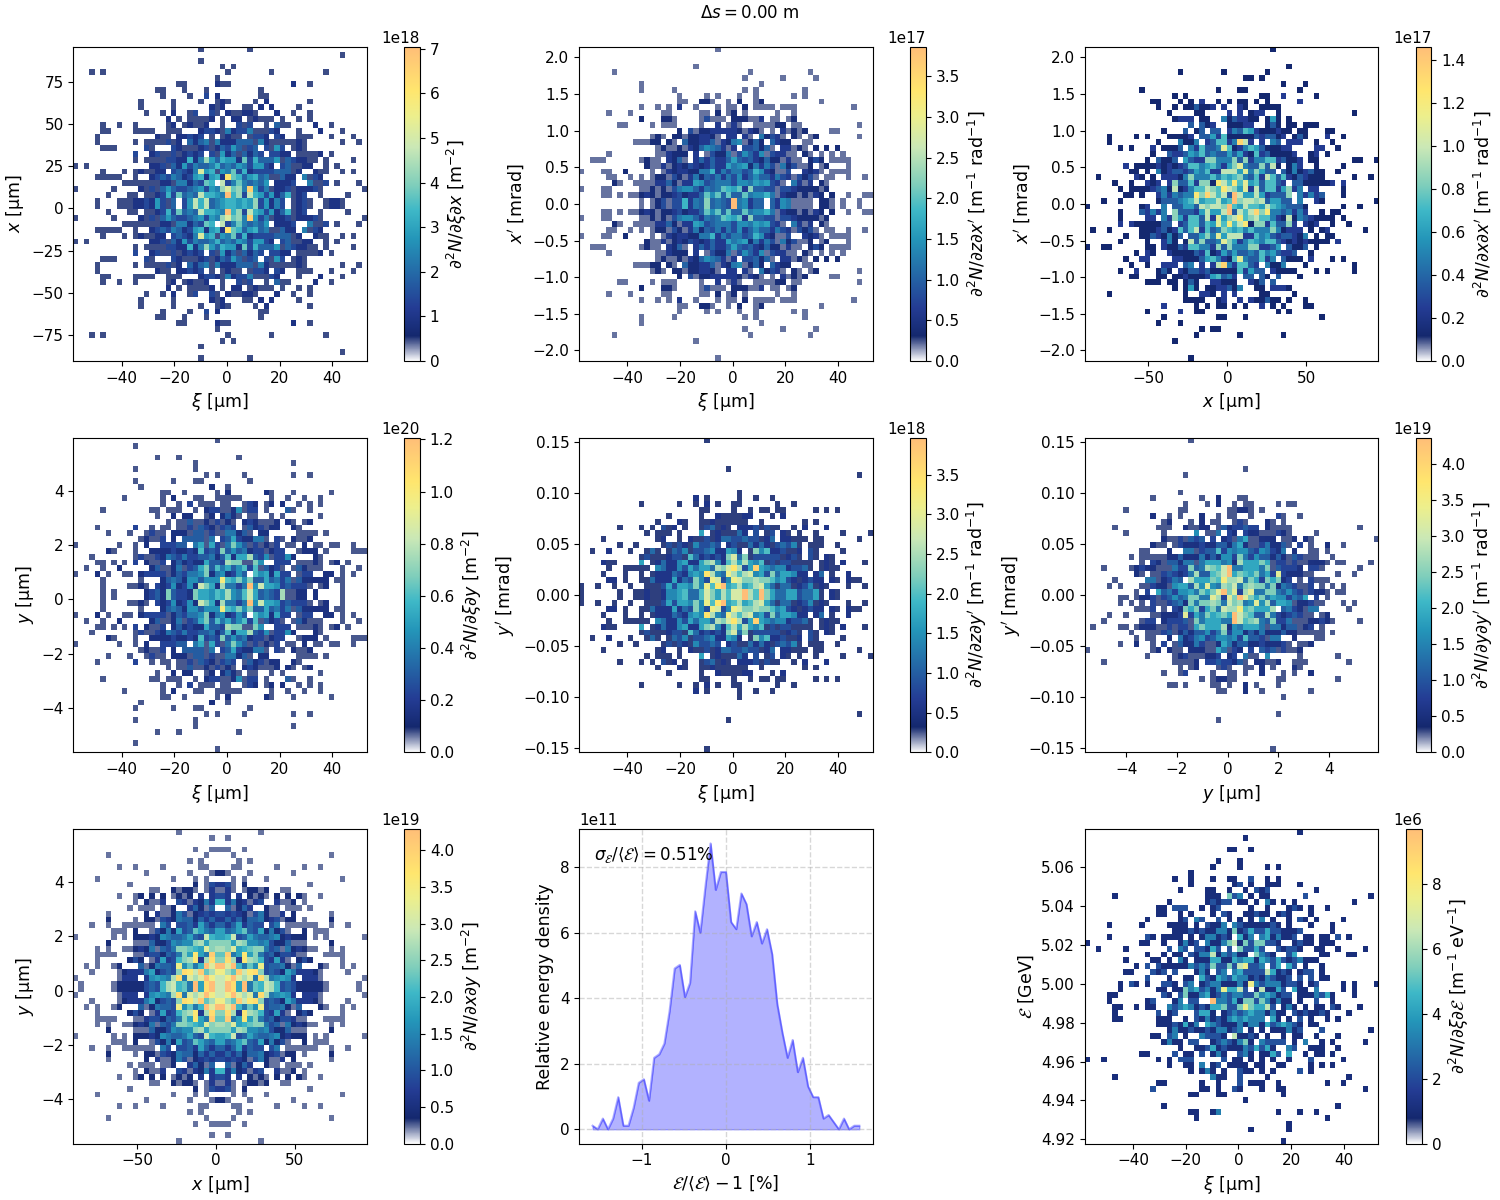

In [5]:
#first_stage.scatter_diags(beam=first_stage.main_beam, n_th_particle=1)
first_stage.density_map_diags(beam=first_stage.main_beam)

## Calculate input longitudinal field, plasma bubble radius and longitudinal number profile with Wake-T

In [6]:
# Define a Wake-T stage
stage_wakeT = StageWakeT()
stage_wakeT.driver_source = driver
k_beta = k_p(stage.plasma_density)/np.sqrt(2*min(main_beam.gamma(),drive_beam.gamma()/2))
lambda_betatron = (2*np.pi/k_beta)
stage_wakeT.length = lambda_betatron/10  # [m]
stage_wakeT.plasma_density = stage.plasma_density  # [m^-3]
#stage_wakeT.keep_data = True

# Run the Wake-T stage
beam_copy = copy.deepcopy(main_beam)
beam_wakeT = stage_wakeT.track(beam_copy)

Plasma stage: 100%|███████████████████████████████████████████| 0.005582/0.005582 m [00:00]


/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/Software/opal_env/lib/python3.10/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))


### Extract data

In [7]:
# Extract initial beam densities
beams_dens = stage_wakeT.initial.beam.density.rho
beams_extent = stage_wakeT.initial.beam.density.extent

# Extract transverse fields
Ex = stage_wakeT.initial.plasma.wakefield.Exs
By = stage_wakeT.initial.plasma.wakefield.Bys
info_Ex = stage_wakeT.initial.plasma.wakefield.Exs_metadata
Ex_cBy = Ex - c*By
zs_Ex = info_Ex.z
rs_Ex = info_Ex.r

# Extract longitudinal E-field
Ez_wakeT = stage_wakeT.initial.plasma.wakefield.Ezs
info_Ez = stage_wakeT.initial.plasma.wakefield.Ezs_metadata
zs_Ez_wakeT = info_Ez.z
rs_Ez = info_Ez.r

# Extract axial longitudinal E-field
Ez_axis_wakeT = stage_wakeT.initial.plasma.wakefield.onaxis.Ezs
zs_Ez_wakeT = stage_wakeT.initial.plasma.wakefield.onaxis.zs

# Extract plasma charge density
rho = stage_wakeT.initial.plasma.density.rho
info_rho = stage_wakeT.initial.plasma.density.metadata

# Calculate the number density
plasma_num_density = rho/stage_wakeT.plasma_density
# Extract coordinates
zs_rho = info_rho.z
rs_rho = info_rho.r

# Extract the plasma bubble radius
bubble_radius_wakeT = first_stage.get_bubble_radius(plasma_num_density, rs_rho, main_offset=main_beam.x_offset(), threshold=0.8)

# Extract number density profiles for drive and main beam
zs_dNdz = stage_wakeT.initial.beam.current.zs
dNdz = stage_wakeT.initial.beam.current.Is/-e/c

### Make plots

Text(0, 0.5, '$\\partial N/\\partial z$ [$\\mathrm{m}^{-1}$]')

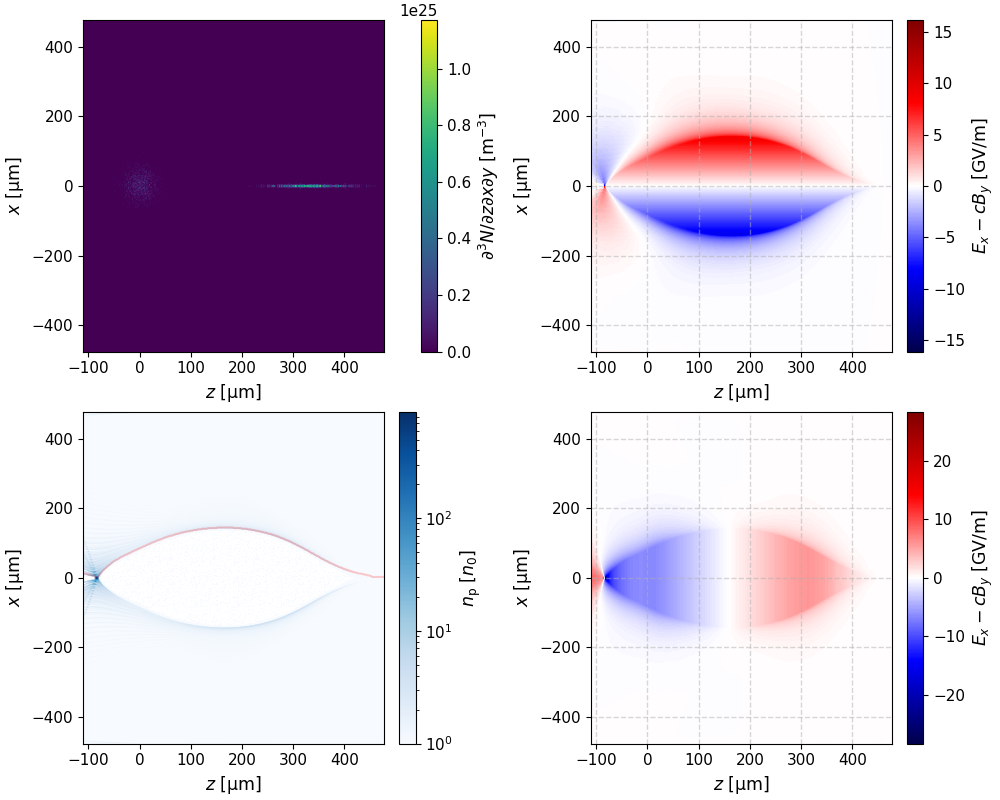

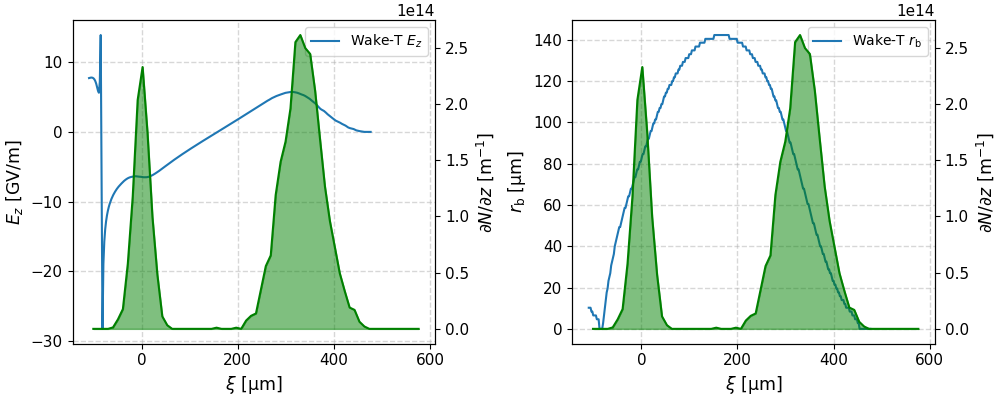

In [8]:
# Labels for plots
zlab = '$z$ [$\mathrm{\mu}$m]'
xilab = r'$\xi$ [$\mathrm{\mu}$m]'
xlab = '$x$ [$\mathrm{\mu}$m]'
field_lab = '$E_z$ [GV/m]'
dN_dz_lab = '$\partial N/\partial z$ [$\mathrm{m}^{-1}$]'

# Set up a figure with axes
fig_wakeT, axs_wakeT = plt.subplots(nrows=2, ncols=2, layout="constrained", figsize=(10, 4*2))

# Plot the bunches
first_stage.imshow_plot(beams_dens, axes=axs_wakeT[0][0], extent=beams_extent*1e6, colmap='viridis', xlab=zlab, ylab=xlab, clab='$\partial^3 N/\partial z\partial x\partial y$ [$\mathrm{m}^{-3}$]', gridOn=False, origin='lower', log_cax=False)

# Plot the transverse fields
Ex_extent = stage_wakeT.initial.plasma.wakefield.Exs_metadata.imshow_extent*1e6
first_stage.imshow_plot(Ex_cBy/1e9, axes=axs_wakeT[0][1], extent=Ex_extent, vmin=Ex_cBy.min()/1e9, vmax=-Ex_cBy.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')

# Plot the plasma number density
rho_extent = stage_wakeT.initial.plasma.density.extent*1e6
first_stage.imshow_plot(plasma_num_density, axes=axs_wakeT[1][0], extent=rho_extent, colmap='Blues', xlab=zlab, ylab=xlab, clab='$n_\mathrm{p}$ [$n_0$]', gridOn=False, origin='lower', log_cax=True)
axs_wakeT[1][0].plot(zs_rho*1e6, (bubble_radius_wakeT+main.x_offset)*1e6, 'r', alpha=0.2)

# Plot the longitudinal electric field
Ez_extent = stage_wakeT.initial.plasma.wakefield.Ezs_metadata.imshow_extent*1e6
first_stage.imshow_plot(Ez_wakeT/1e9, axes=axs_wakeT[1][1], extent=Ez_extent, vmin=Ez_wakeT.min()/1e9, vmax=-Ez_wakeT.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')

# Set up a figure with axes
fig_wakeT2, axs_wakeT2 = plt.subplots(nrows=1, ncols=2, layout="compressed", figsize=(10, 4))
#fig_wakeT2.suptitle('$t=$' f'{format(dump_time, ".2e")}' ' s')

# Plot longitudinal axial E-field
axs_wakeT2[0].plot(zs_Ez_wakeT*1e6, Ez_axis_wakeT/1e9, label='Wake-T $E_z$')
axs_wakeT2[0].legend()
axs_wakeT2[0].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[0].set_xlabel(xilab)
axs_wakeT2[0].set_ylabel(field_lab)
ax = axs_wakeT2[0].twinx()
ax.fill_between(x=zs_dNdz*1e6, y1=dNdz , y2=0, color='g', alpha=0.5)
ax.plot(zs_dNdz*1e6, dNdz, 'g')
ax.set_ylabel(dN_dz_lab)

# Plot the plasma bubble radius
axs_wakeT2[1].plot((zs_rho)*1e6, bubble_radius_wakeT*1e6, label='Wake-T $r_\mathrm{b}$')
axs_wakeT2[1].legend()
axs_wakeT2[1].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[1].set_xlabel(xilab)
axs_wakeT2[1].set_ylabel('$r_\mathrm{b}$ [$\mathrm{\mu}$m]')
ax = axs_wakeT2[1].twinx()
ax.fill_between(x=zs_dNdz*1e6, y1=dNdz , y2=0, color='g', alpha=0.5)
ax.plot(zs_dNdz*1e6, dNdz, 'g')
ax.set_ylabel(dN_dz_lab)


#stage_wakeT.plot_evolution()
#beam_wakeT.plot_lps()

## Summary of initial beam

In [9]:
_, init_Ez_fit_obj = first_stage.Ez_shift_fit(Ez_axis_wakeT, zs_Ez_wakeT, main_beam)
first_stage.Ez_fit_obj = init_Ez_fit_obj

_, init_rb_fit_obj = first_stage.rb_shift_fit(bubble_radius_wakeT, zs_rho, main_beam)
first_stage.rb_fit_obj = init_rb_fit_obj

first_stage.print_initial_summary(first_drive_beam, main_beam)

Time step [betatron wavelength/c]:			 0.015
Interstages enabled:					 True
Interstage dipole field:				 0.500
Symmetrised main beam:					 True
Symmetrised drive beam:					 True

Stage length [m]:					 5.000
Plasma density [m^-3]:					 7.000e+21
Ramp beta magnification:				 5.000
Drive beam x jitter (std) [um]:				 0.000
Drive beam y jitter (std) [um]:				 0.000
----------------------------------------------------------------------

-------------------------------------------------------------------------------------
Quantity 					 Drive beam 		 Main beam
-------------------------------------------------------------------------------------
Number of macroparticles:			 10000			 6000
Initial beam population:			 2.700e+10 		 1.000e+10

Beam centre gradient [GV/m]:				  		 -6.468
Initial mean gamma:				 61154.724 		 9782.076
Initial mean energy [GeV]:			 31.250 		 4.999
Initial rms energy spread [%]:			 0.000 			 0.510

Initial beam x offset [um]:			 -0.000 		 2.695
Initial beam y offset [u

## Perform tracking

In [10]:
import time

# Start time
start_time = time.time()
cpu_start_time = time.process_time()

# Tracking
linac.run(notebook_name, overwrite=overwrite)

# End time
end_time = time.time()
cpu_end_time = time.process_time()

# Time usage
print('Time taken:', end_time - start_time, 'seconds')
print('CPU seconds:', cpu_end_time - cpu_start_time)

Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 5.0 GeV, -1.60 nC, 0.5% rms, 159.7/0.5 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.005582/0.005582 m [00:00]


Instability tracking 100.01%: 100%|███████| 100.00899312233113/100 [01:33<00:00,  1.06it/s]


Tracking element 2 (StagePrtclTransWakeInstability, stage 1, s = 5.0 m, 20.9 GeV, -1.60 nC, 7.7% rms, 163.5/0.5 µm-rad)
Tracking element 3 (InterstageBasic, stage 1, s = 11.9 m, 20.9 GeV, -1.60 nC, 7.7% rms, 163.7/0.5 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.01%: 100%|███████| 100.00525597047636/100 [03:12<00:00,  1.92s/it]


Tracking element 4 (StagePrtclTransWakeInstability, stage 2, s = 16.9 m, 52.7 GeV, -1.60 nC, 3.7% rms, 164.5/0.5 µm-rad)
Tracking element 5 (InterstageBasic, stage 2, s = 28.0 m, 52.7 GeV, -1.60 nC, 3.7% rms, 164.5/0.5 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.03%: 100%|███████| 100.03185345298175/100 [00:28<00:00,  3.52it/s]


Tracking element 6 (StagePrtclTransWakeInstability, stage 3, s = 33.0 m, 85.0 GeV, -1.60 nC, 2.4% rms, 169.2/0.6 µm-rad)
Tracking element 7 (InterstageBasic, stage 3, s = 46.9 m, 85.0 GeV, -1.60 nC, 2.4% rms, 169.1/0.6 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.06%: 100%|███████| 100.06178914477883/100 [24:33<00:00, 14.73s/it]


Tracking element 8 (StagePrtclTransWakeInstability, stage 4, s = 51.9 m, 117.0 GeV, -1.60 nC, 1.7% rms, 183.3/0.6 µm-rad)
Tracking element 9 (InterstageBasic, stage 4, s = 68.3 m, 117.0 GeV, -1.60 nC, 1.7% rms, 183.3/0.6 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.07%: 100%|███████| 100.07007835023865/100 [02:59<00:00,  1.80s/it]


Tracking element 10 (StagePrtclTransWakeInstability, stage 5, s = 73.3 m, 148.9 GeV, -1.60 nC, 1.3% rms, 211.8/0.7 µm-rad)
Tracking element 11 (InterstageBasic, stage 5, s = 91.8 m, 148.9 GeV, -1.60 nC, 1.3% rms, 211.9/0.7 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.08%: 100%|████████| 100.0787996693028/100 [02:50<00:00,  1.70s/it]


Tracking element 12 (StagePrtclTransWakeInstability, stage 6, s = 96.8 m, 180.8 GeV, -1.60 nC, 1.1% rms, 260.7/0.9 µm-rad)
Tracking element 13 (InterstageBasic, stage 6, s = 117.1 m, 180.8 GeV, -1.60 nC, 1.1% rms, 260.8/0.9 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.02%: 100%|███████| 100.01879174226514/100 [00:14<00:00,  6.97it/s]


Tracking element 14 (StagePrtclTransWakeInstability, stage 7, s = 122.1 m, 212.9 GeV, -1.60 nC, 1.0% rms, 323.8/1.1 µm-rad)
Tracking element 15 (InterstageBasic, stage 7, s = 144.2 m, 212.9 GeV, -1.60 nC, 1.0% rms, 324.3/1.1 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.11%: 100%|███████| 100.10870216907688/100 [00:13<00:00,  7.51it/s]


Tracking element 16 (StagePrtclTransWakeInstability, stage 8, s = 149.2 m, 244.7 GeV, -1.60 nC, 0.9% rms, 386.0/1.3 µm-rad)
Tracking element 17 (InterstageBasic, stage 8, s = 172.9 m, 244.7 GeV, -1.60 nC, 0.9% rms, 386.7/1.3 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.05%: 100%|███████| 100.05357980064535/100 [00:12<00:00,  8.08it/s]


Tracking element 18 (StagePrtclTransWakeInstability, stage 9, s = 177.9 m, 276.4 GeV, -1.60 nC, 0.9% rms, 435.6/1.5 µm-rad)
Tracking element 19 (InterstageBasic, stage 9, s = 203.1 m, 276.4 GeV, -1.60 nC, 0.9% rms, 435.3/1.5 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.11%: 100%|████████| 100.1144109012023/100 [00:11<00:00,  8.56it/s]


Tracking element 20 (StagePrtclTransWakeInstability, stage 10, s = 208.1 m, 308.3 GeV, -1.60 nC, 0.8% rms, 464.5/1.6 µm-rad)
Tracking element 21 (InterstageBasic, stage 10, s = 234.7 m, 308.3 GeV, -1.60 nC, 0.8% rms, 464.0/1.6 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.08%: 100%|███████| 100.07903201865842/100 [00:11<00:00,  9.03it/s]


Tracking element 22 (StagePrtclTransWakeInstability, stage 11, s = 239.7 m, 340.6 GeV, -1.60 nC, 0.8% rms, 474.1/1.6 µm-rad)
Tracking element 23 (InterstageBasic, stage 11, s = 267.7 m, 340.6 GeV, -1.60 nC, 0.8% rms, 474.3/1.6 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.08%: 100%|███████| 100.08245458963154/100 [00:10<00:00,  9.55it/s]


Tracking element 24 (StagePrtclTransWakeInstability, stage 12, s = 272.7 m, 372.4 GeV, -1.60 nC, 0.8% rms, 468.4/1.6 µm-rad)
Tracking element 25 (InterstageBasic, stage 12, s = 301.9 m, 372.4 GeV, -1.60 nC, 0.8% rms, 469.0/1.6 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.02%: 100%|███████| 100.01674771954734/100 [00:10<00:00,  9.82it/s]


Tracking element 26 (StagePrtclTransWakeInstability, stage 13, s = 306.9 m, 404.1 GeV, -1.60 nC, 0.8% rms, 456.7/1.6 µm-rad)
Tracking element 27 (InterstageBasic, stage 13, s = 337.4 m, 404.1 GeV, -1.60 nC, 0.8% rms, 457.1/1.6 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.13%: 100%|███████| 100.13047594268987/100 [00:09<00:00, 10.36it/s]


Tracking element 28 (StagePrtclTransWakeInstability, stage 14, s = 342.4 m, 436.4 GeV, -1.60 nC, 0.8% rms, 445.5/1.5 µm-rad)
Tracking element 29 (InterstageBasic, stage 14, s = 374.1 m, 436.4 GeV, -1.60 nC, 0.8% rms, 445.6/1.5 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.14%: 100%|███████| 100.14488240954054/100 [00:09<00:00, 10.93it/s]


Tracking element 30 (StagePrtclTransWakeInstability, stage 15, s = 379.1 m, 469.0 GeV, -1.60 nC, 0.8% rms, 442.9/1.5 µm-rad)
Tracking element 31 (InterstageBasic, stage 15, s = 411.8 m, 469.0 GeV, -1.60 nC, 0.8% rms, 442.9/1.5 µm-rad)
Plasma stage: 100%|███████████████████████████████████████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.09%: 100%|███████| 100.08640663156632/100 [00:08<00:00, 11.31it/s]


Tracking element 32 (StagePrtclTransWakeInstability, stage 16, s = 416.8 m, 501.4 GeV, -1.60 nC, 0.8% rms, 450.3/1.5 µm-rad)
Time taken: 2262.867791891098 seconds
CPU seconds: 151.97186299999998


In [11]:
shot_num = 0
stage_num = 15
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

stage_tracked.print_current_summary(stage_tracked.drive_beam, linac.initial_beam, beam_out)

Time step [betatron wavelength/c]:	 0.015
Interstages enabled:			 True
Interstage dipole field:		 0.500
Symmetrised main beam:			 True
Symmetrised drive beam:			 True

Stage length [m]:			 5.000
Propagation length [m]:			 416.841
Plasma density [m^-3]:			 7.000e+21
Ramp beta magnification:		 5.000
Drive beam x jitter (std) [um]:		 0.000
Drive beam y jitter (std) [um]:		 0.000
---------------------------------------------------

-------------------------------------------------------------------------------------
Quantity 					 Drive beam 		 Main beam
-------------------------------------------------------------------------------------
Initial number of macroparticles:		 10000			 6000
Current number of macroparticles:		  			 6000
Initial beam population:			 2.700e+10 		 1.000e+10
Current beam population:			 	 		 1.000e+10

Beam centre gradient [GV/m]:				  		 -6.456
Current mean gamma:				 	 		 981182.084
Initial mean energy [GeV]:			 31.250 		 4.999
Current mean energy [GeV]:			 	 		 5

## Diagnostic of extracted beam

In [12]:
# Make plots folder
plot_path = stage_tracked.diag_path + 'plots' + os.sep
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

### Cut-out bubble radius, longitudinal E-field and longitudinal beam profile

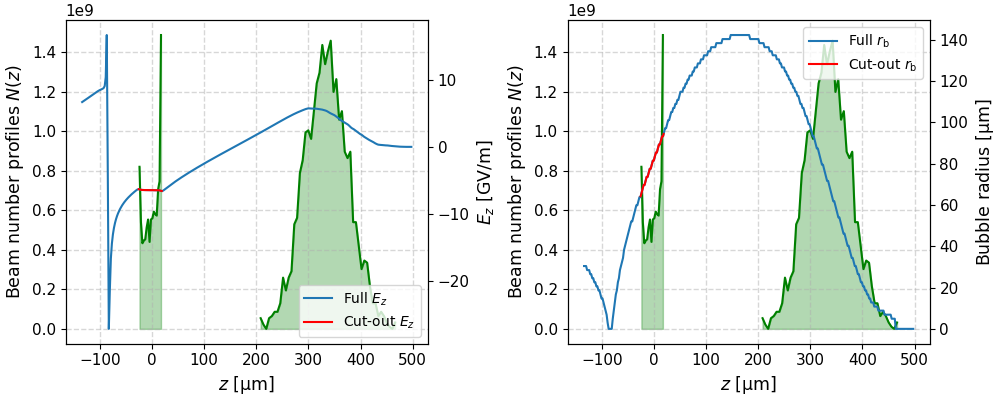

In [13]:
stage_tracked.plot_Ez_rb_cut()

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'Ez_rb_' + 'shot' + str(shot_num) + '_prtclInstabilityStage' + str(stage_num)
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

### Beam particle plots

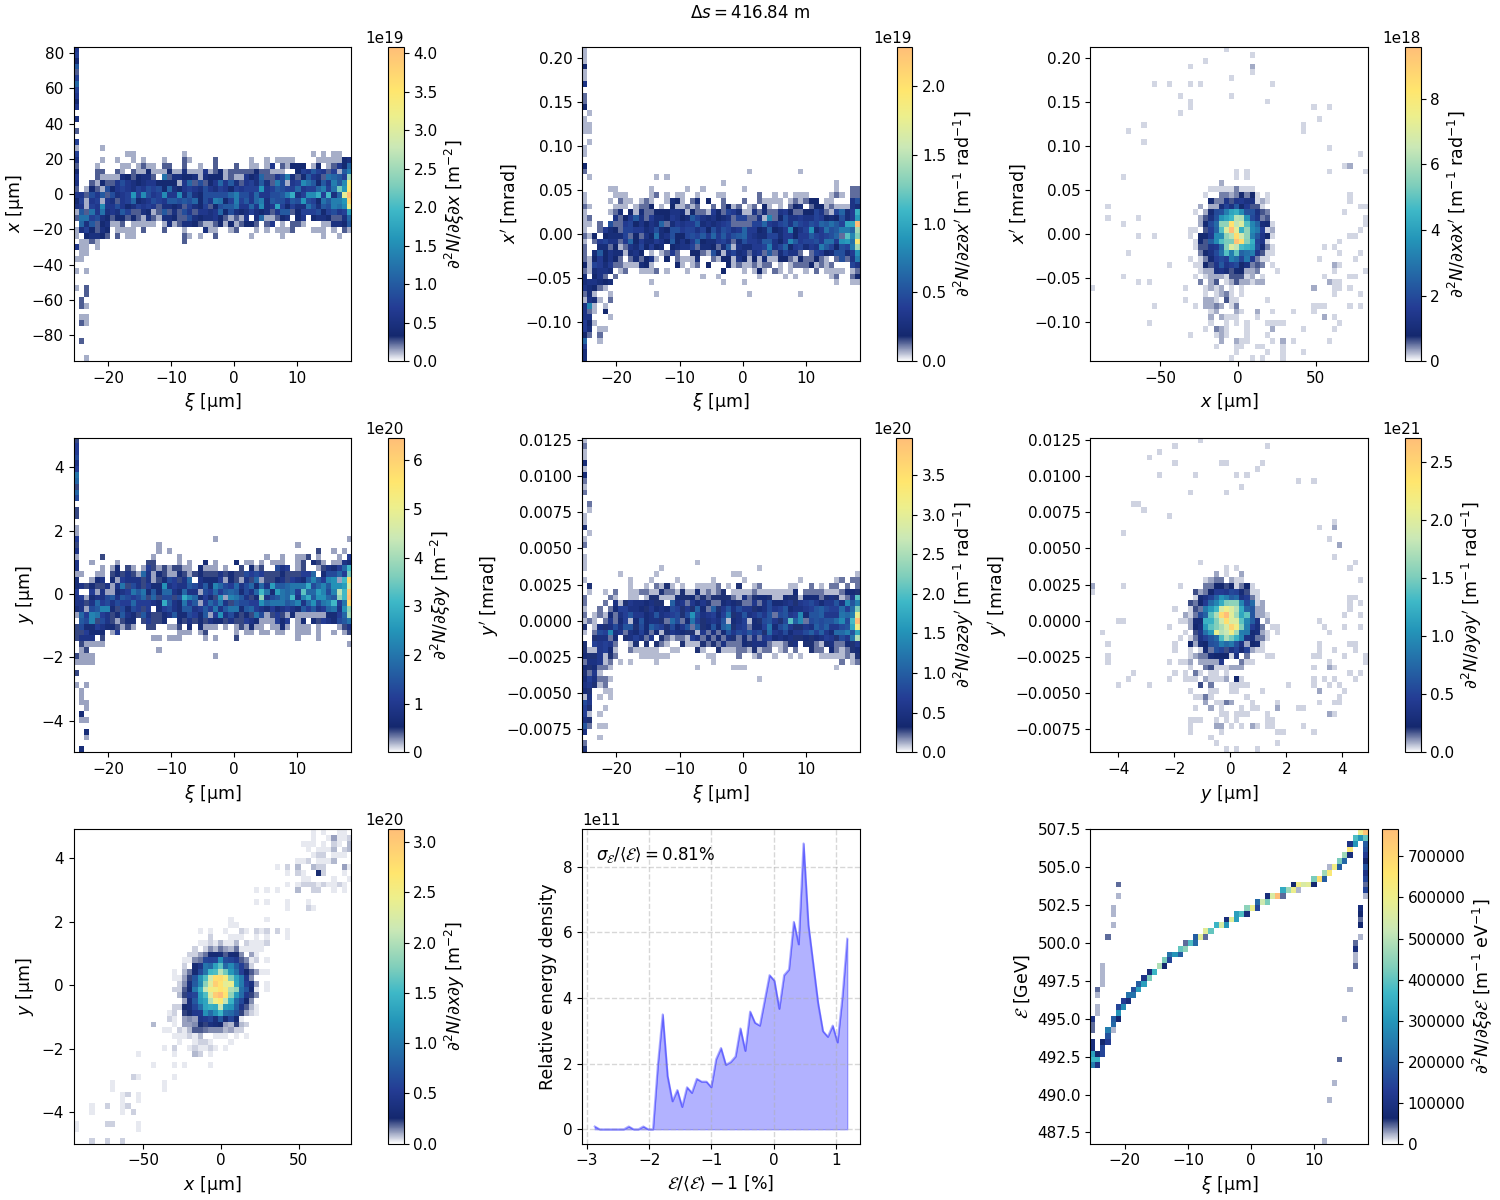

In [14]:
stage_tracked.density_map_diags(beam=beam_out)

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'densMaps_' + 'shot' + str(shot_num) + '_prtclInstabilityStage' + str(stage_num)
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

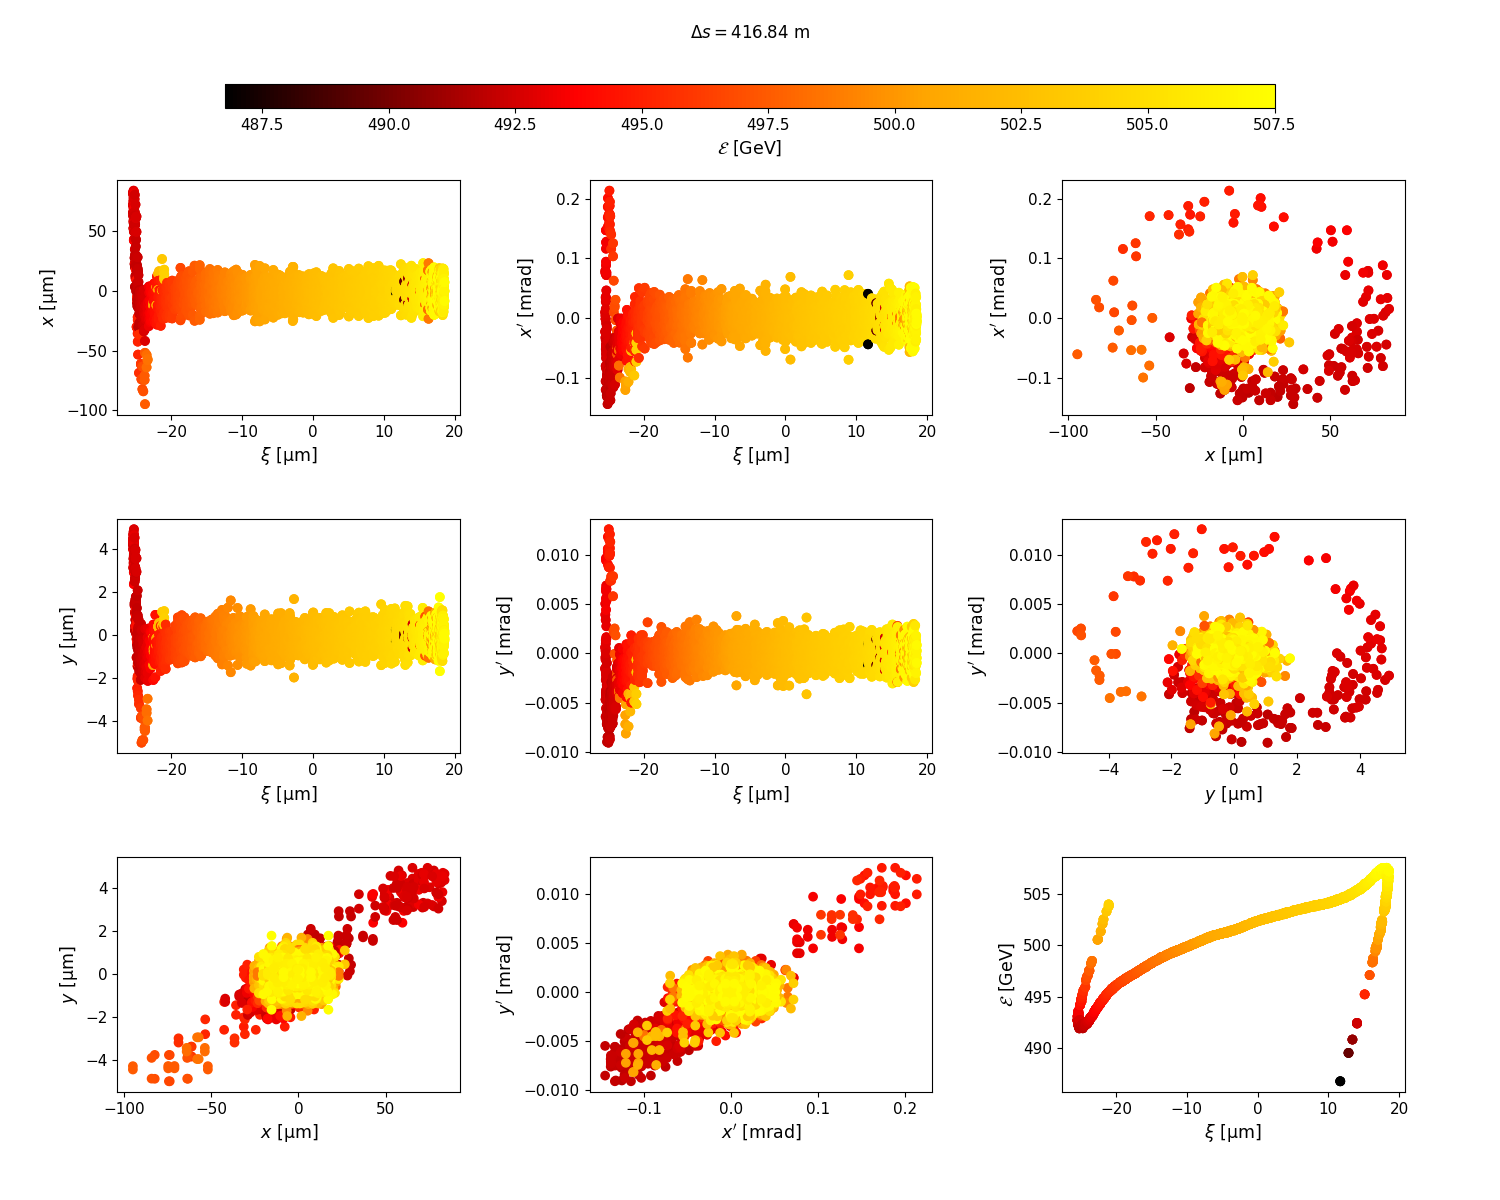

In [15]:
stage_tracked.scatter_diags(beam=beam_out, n_th_particle=1)

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'scatter_' + 'prtclInstabilityStage_' + 'shot' + str(shot_num) + '_prtclInstabilityStage' + str(stage_num)
    plt.savefig(filename, format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

## Plot beam evolution and survey

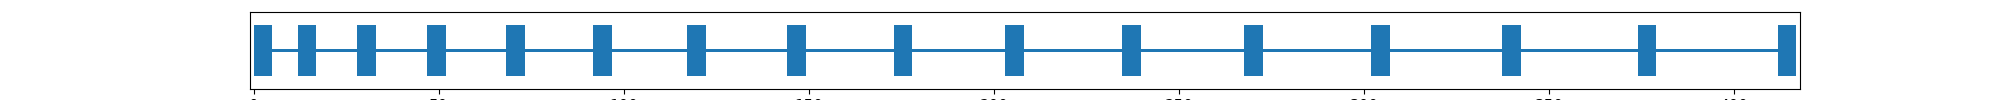

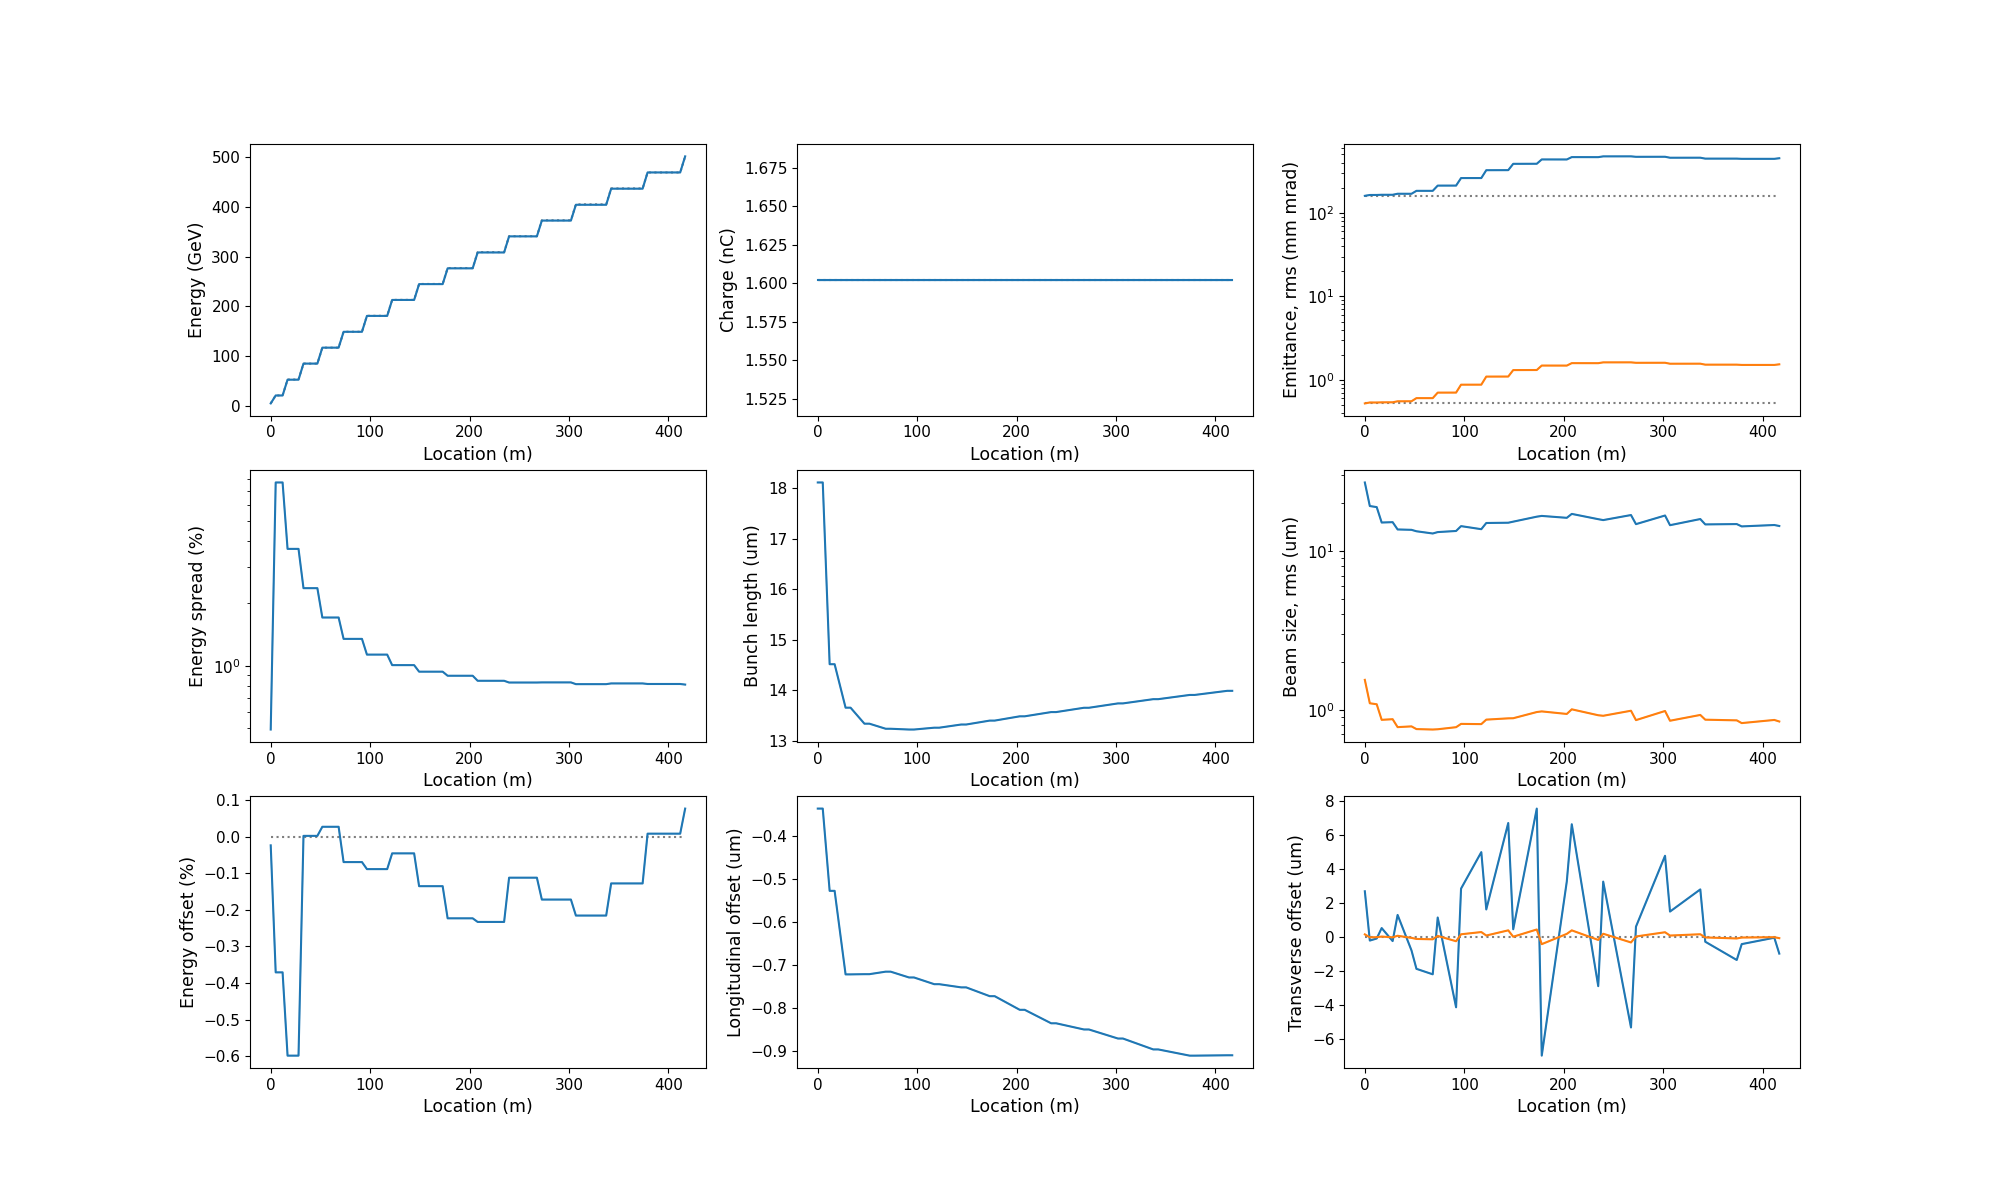

In [16]:
# plot linac survey
linac.plot_survey()

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'sketch_evolution_' + 'shot' + str(shot_num)
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)


# plot beam evolution
linac.plot_evolution()

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'evolution_' + 'shot' + str(shot_num)
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

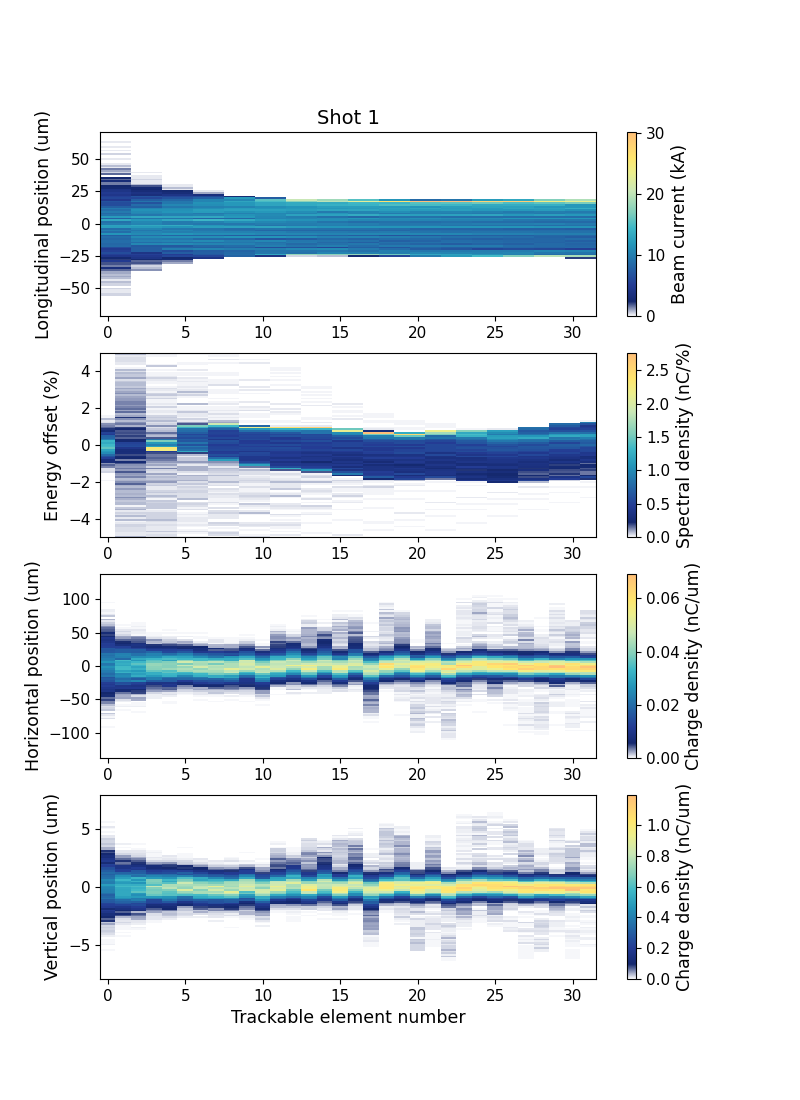

In [17]:
linac.plot_waterfalls()

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'waterfalls_'  + 'shot' + str(shot_num)
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [18]:
if overwrite is True:
    params = {
    'axes.titlesize': 13,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9
    }
    pylab.rcParams.update(params)
    
    linac.animate_lps()
    linac.animate_phasespace_x()
    linac.animate_phasespace_y()
    linac.animate_sideview_x()
    linac.animate_sideview_y()
else:
    sys.exit('Abort running the rest of the notebook.')

## Isolate some plots for saving

In [19]:
ss, vals_mean, vals_std, stage_nums = linac.evolution_fcn([Beam.abs_charge, \
                                             Beam.energy, Beam.rel_energy_spread, \
                                             Beam.bunch_length, Beam.z_offset, \
                                             Beam.norm_emittance_x, Beam.norm_emittance_y, \
                                             Beam.beta_x, Beam.beta_y, \
                                             Beam.x_offset, Beam.y_offset])


# mean values
Qs = vals_mean[:,0]
mean_Es = vals_mean[:,1]
sigdeltas = vals_mean[:,2]
#sigzs = vals_mean[:,3]
z0s = vals_mean[:,4]
emnxs = vals_mean[:,5]
emnys = vals_mean[:,6]
betaxs = vals_mean[:,7]
betays = vals_mean[:,8]
x0s = vals_mean[:,9]
y0s = vals_mean[:,10]

# nominal energies
Es_nom = linac.nom_stage_energies()

# Set default font sizes for figures
params = {
    #'figure.figsize': (15, 5),
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14
}
pylab.rcParams.update(params)

# Set default Latex fonts
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#plt.rcParams['text.latex.preamble'] = r'\usepackage{mathrsfs}'
#plt.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}'

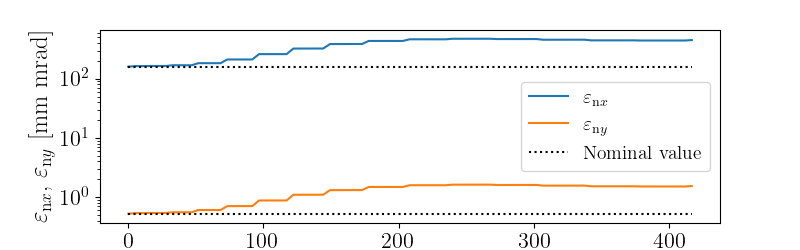

In [20]:
fig, ax= plt.subplots(figsize=(8, 2.5))

# Normalised emittances vs. s
ax.plot(ss, emnxs*1e6, label=r'$\varepsilon_{\mathrm{n}x}$')
ax.plot(ss, emnys*1e6, label=r'$\varepsilon_{\mathrm{n}y}$')
ax.plot(ss, np.ones(len(ss))*emnxs[0]*1e6, 'k:', label='Nominal value')
ax.plot(ss, np.ones(len(ss))*emnys[0]*1e6, 'k:')
ax.set_yscale('log')
#ax.set_ylabel('Norm. emitt. [mm mrad]', fontsize=14)
ax.set_ylabel(r'$\varepsilon_{\mathrm{n}x}$, $\varepsilon_{\mathrm{n}y}$ [mm mrad]', fontsize=18)
ax.set_xlabel('$s$ [m]')
#ax.legend(loc='right', fontsize=14)
ax.legend(fontsize=14)
#fig.savefig('norm_emitt_vs_s.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'norm_emitt_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'norm_emitt_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

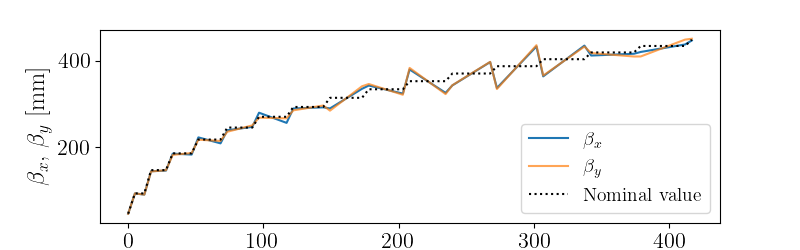

In [21]:
fig, ax = plt.subplots(figsize=(8, 2.5))

# Beta functions vs. s
ax.plot(ss, betaxs*1e3, label=r'$\beta_{x}$')
ax.plot(ss, betays*1e3, label=r'$\beta_{y}$', alpha=0.7)
ax.plot(ss, np.sqrt(Es_nom/Es_nom[0])*betaxs[0]*1e3, 'k:', label='Nominal value')
#ax.set_yscale('log')
#ax.set_ylabel('Beta function [mm]')
ax.set_ylabel(r'$\beta_{x}$, $\beta_{y}$ [mm]')
ax.set_xlabel('$s$ [m]')
ax.legend(fontsize=14)

#ax_twin = ax.twinx()
#ax_twin.plot(ss, Qs*1e9, 'r', label='Charge')
#ax_twin.set_ylabel('Charge [nC]')
#
## Gather the legends of both axes and display them together
#lines1, labels1 = ax.get_legend_handles_labels()
#lines2, labels2 = ax_twin.get_legend_handles_labels()
#lines = lines1 + lines2
#labels = labels1 + labels2
#
#ax.legend(lines, labels)
#ax.legend(lines, labels, loc='lower right')

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'beta_func_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'beta_func_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

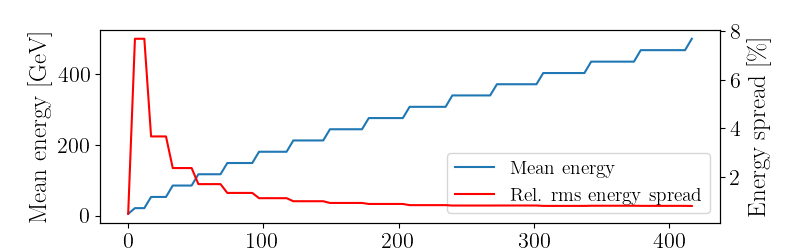

In [22]:
fig, ax = plt.subplots(figsize=(8, 2.5))

# Energy and energy spread functions vs. s
#ax.plot(ss, mean_Es/1e9, label='$\mathcal{E}$')
ax.plot(ss, mean_Es/1e9, label='Mean energy')
ax_twin = ax.twinx()
#ax_twin.plot(ss, sigdeltas*1e2, 'r', label='$\sigma_\mathcal{E}/\mathcal{E}$')
ax_twin.plot(ss, sigdeltas*1e2, 'r', label='Rel. rms energy spread')

#ax.set_yscale('log')
ax.set_ylabel('Mean energy [GeV]')
ax_twin.set_ylabel(r'Energy spread [\%]')
ax.set_xlabel('$s$ [m]')

# Gather the legends of both axes and display them together
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax.legend(lines, labels, fontsize=14, loc='lower right')
# Set the facecolor of the plot box to be opaque
#fig.patch.set_facecolor('none')
#fig.patch.set_alpha(0.0)
#ax.patch.set_facecolor('none')
#ax.patch.set_alpha(1.0)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'energy_energy_spread_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'energy_energy_spread_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

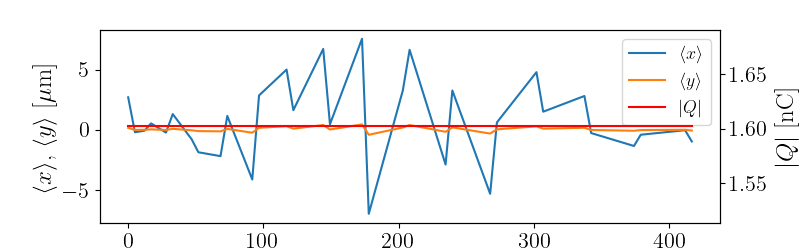

In [23]:
fig, ax = plt.subplots(figsize=(8, 2.5))

# Mean transverse offsets vs. s
ax.plot(ss, x0s*1e6, label=r'$\langle x \rangle$')
ax.plot(ss, y0s*1e6, label=r'$\langle y \rangle$')
#ax.plot(ss, np.zeros(len(ss)), 'k:', label='Nominal value')
#ax.set_yscale('log')
#ax.set_ylabel('Trans. offset [$\mathrm{\mu}$m]')
ax.set_ylabel(r'$\langle x \rangle$, $\langle y \rangle$ [$\mathrm{\mu}$m]')
ax.set_xlabel('$s$ [m]')
#ax.legend(loc='upper right')

ax_twin = ax.twinx()
ax_twin.plot(ss, Qs*1e9, 'r', label='$|Q|$')
ax_twin.set_ylabel('$|Q|$ [nC]')
ax.set_xlabel('$s$ [m]')

# Gather the legends of both axes and display them together
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2

ax.legend(lines, labels, fontsize=13)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'tr_offset_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'tr_offset_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [24]:
# Customised colour map
#colors = ['white', 'mediumblue', 'aquamarine', 'limegreen', 'yellow', 'orangered']
#colors = ['white', 'mediumblue', 'darkcyan', 'aquamarine', 'lightgreen', 'mediumseagreen', 'green']
#colors = ['white', 'forestgreen', 'limegreen', 'lawngreen', 'aquamarine', 'deepskyblue']
#colors = ['white', 'forestgreen', 'lawngreen', 'aquamarine', 'deepskyblue', 'royalblue']
#colors = ['white', 'seagreen', 'green', 'springgreen', 'yellow', 'orangered']
#bounds = [0, 0.2, 0.4, 0.8, 1]
#cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=256)


#from abel.utilities.colors import *
import abel.utilities.colors as cmaps
cmap = cmaps.FLASHForward

# Labels for plots
ylab = '$y$ [$\mathrm{\mu}$m]'
xps_lab = '$x\'$ [mrad]'
yps_lab = '$y\'$ [mrad]'
energ_lab = '$\mathcal{E}$ [GeV]'

# Macroparticles data
zs = beam_out.zs()
xs = beam_out.xs()
xps = beam_out.xps()
ys = beam_out.ys()
yps = beam_out.yps()
Es = beam_out.Es()
weights = beam_out.weightings()

nbins = int(np.sqrt(len(weights)/2))
hist_bins = [ nbins, nbins ]  # list of 2 ints. Number of bins along each direction, for the histograms

# Set default font sizes for figures
densMap_params = {
    'figure.figsize': (6, 5),
    'axes.labelsize': 20,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 14
}
pylab.rcParams.update(densMap_params)

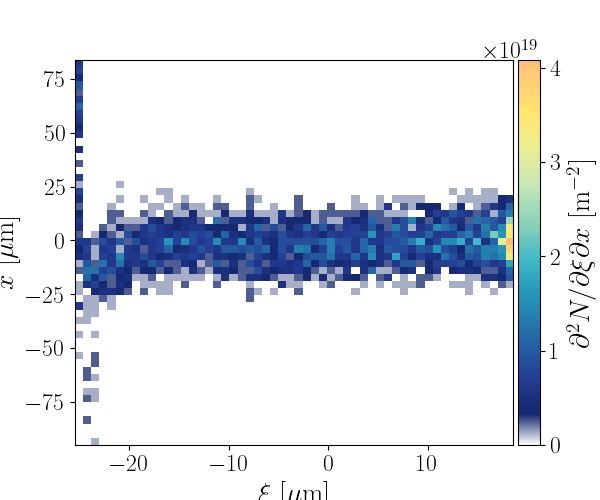

In [25]:
# 2D z-x distribution
fig, ax = plt.subplots()
hist_range = [[None, None], [None, None]]
hist_range[0] = [ zs.min(), zs.max() ]  # [m], list contains 2 lists of 2 floats. Extent of the histogram along each direction
hist_range[1] = [ xs.min(), xs.max() ]
extent_zx = hist_range[0] + hist_range[1]
extent_zx = [i*1e6 for i in extent_zx]  # [um]
stage_tracked.distribution_plot_2D(arr1=zs, arr2=xs, weights=weights, hist_bins=hist_bins, hist_range=hist_range, axes=ax, extent=extent_zx, vmin=None, vmax=None, colmap=cmap, xlab=xilab, ylab=xlab, clab=r'$\partial^2 N/\partial\xi \partial x$ [$\mathrm{m}^{-2}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_xi_x_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_xi_x_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

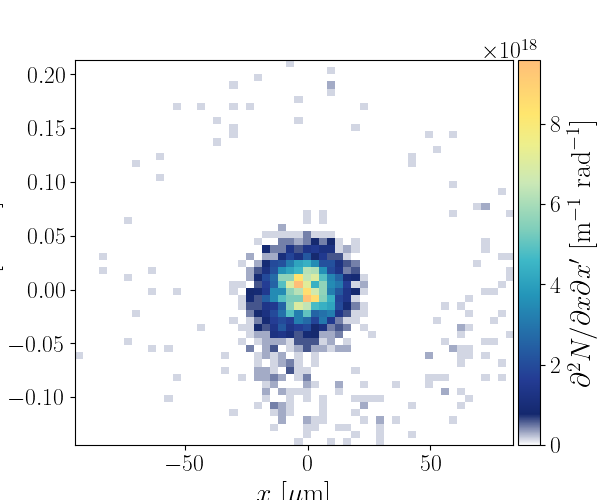

In [26]:
# 2D z-x' distribution
fig, ax = plt.subplots()
hist_range_xxp = [[None, None], [None, None]]
hist_range_xxp[0] = hist_range[1]
hist_range_xxp[1] = [ xps.min(), xps.max() ]  # [rad]
extent_xxp = hist_range_xxp[0] + hist_range_xxp[1]
extent_xxp[0] = extent_xxp[0]*1e6  # [um]
extent_xxp[1] = extent_xxp[1]*1e6  # [um]
extent_xxp[2] = extent_xxp[2]*1e3  # [mrad]
extent_xxp[3] = extent_xxp[3]*1e3  # [mrad]
stage_tracked.distribution_plot_2D(arr1=xs, arr2=xps, weights=weights, hist_bins=hist_bins, hist_range=hist_range_xxp, axes=ax, extent=extent_xxp, vmin=None, vmax=None, colmap=cmap, xlab=xlab, ylab=xps_lab, clab='$\partial^2 N/\partial x\partial x\'$ [$\mathrm{m}^{-1}$ $\mathrm{rad}^{-1}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_x_xp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_x_xp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

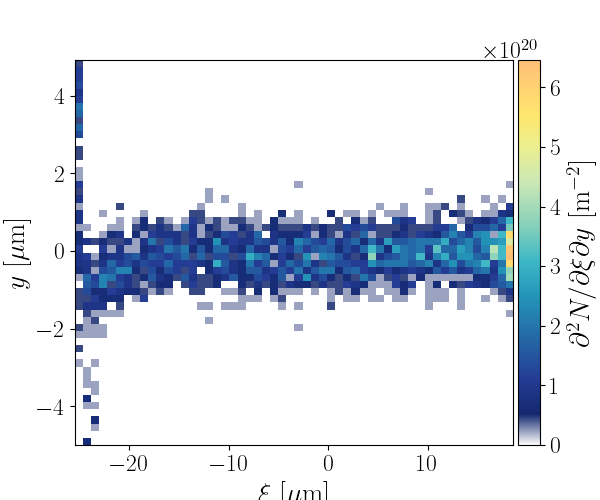

In [27]:
# 2D z-y distribution
fig, ax = plt.subplots()
hist_range_zy = [[None, None], [None, None]]
hist_range_zy[0] = hist_range[0]
hist_range_zy[1] = [ ys.min(), ys.max() ]
extent_zy = hist_range_zy[0] + hist_range_zy[1]
extent_zy = [i*1e6 for i in extent_zy]  # [um]
stage_tracked.distribution_plot_2D(arr1=zs, arr2=ys, weights=weights, hist_bins=hist_bins, hist_range=hist_range_zy, axes=ax, extent=extent_zy, vmin=None, vmax=None, colmap=cmap, xlab=xilab, ylab=ylab, clab=r'$\partial^2 N/\partial\xi \partial y$ [$\mathrm{m}^{-2}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_xi_y_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_xi_y_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

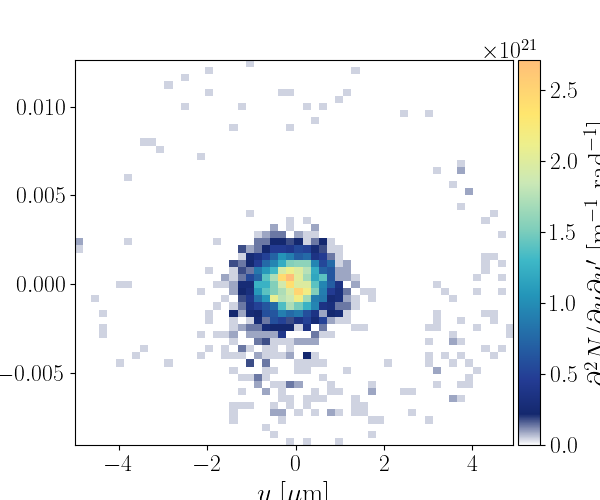

In [28]:
# 2D y-y' distribution
fig, ax = plt.subplots()
hist_range_yyp = [[None, None], [None, None]]
hist_range_yyp[0] = hist_range_zy[1]
hist_range_yyp[1] = [ yps.min(), yps.max() ]  # [rad]
extent_yyp = hist_range_yyp[0] + hist_range_yyp[1]
extent_yyp[0] = extent_yyp[0]*1e6  # [um]
extent_yyp[1] = extent_yyp[1]*1e6  # [um]
extent_yyp[2] = extent_yyp[2]*1e3  # [mrad]
extent_yyp[3] = extent_yyp[3]*1e3  # [mrad]
stage_tracked.distribution_plot_2D(arr1=ys, arr2=yps, weights=weights, hist_bins=hist_bins, hist_range=hist_range_yyp, axes=ax, extent=extent_yyp, vmin=None, vmax=None, colmap=cmap, xlab=ylab, ylab=yps_lab, clab='$\partial^2 N/\partial y\partial y\'$ [$\mathrm{m}^{-1}$ $\mathrm{rad}^{-1}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_y_yp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_y_yp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

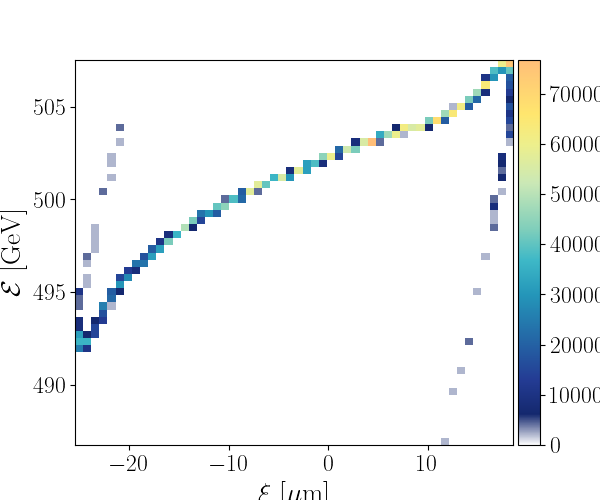

In [29]:
# 2D z-energy distribution
fig, ax = plt.subplots()
hist_range_energ = [[None, None], [None, None]]
hist_range_energ[0] = hist_range[0]
hist_range_energ[1] = [ Es.min(), Es.max() ]  # [eV]
extent_energ = hist_range_energ[0] + hist_range_energ[1]
extent_energ[0] = extent_energ[0]*1e6  # [um]
extent_energ[1] = extent_energ[1]*1e6  # [um]
extent_energ[2] = extent_energ[2]/1e9  # [GeV]
extent_energ[3] = extent_energ[3]/1e9  # [GeV]
stage_tracked.distribution_plot_2D(arr1=zs, arr2=Es, weights=weights, hist_bins=hist_bins, hist_range=hist_range_energ, axes=ax, extent=extent_energ, vmin=None, vmax=None, colmap=cmap, xlab=xilab, ylab=energ_lab, clab=r'$\partial^2 N/\partial \xi \partial\mathcal{E}$ [$\mathrm{m}^{-1}$ $\mathrm{eV}^{-1}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_xi_energy_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_xi_energy_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

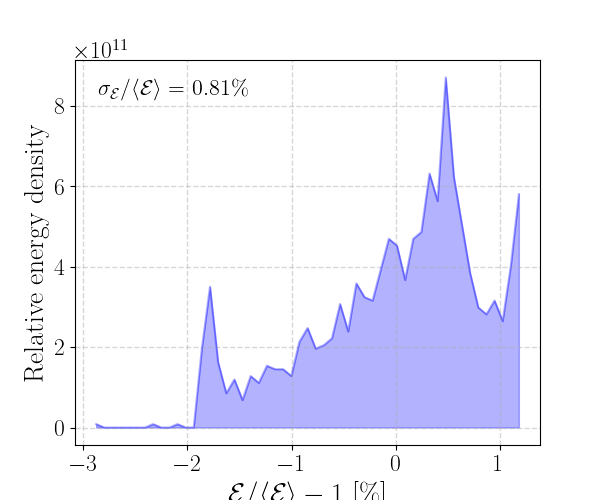

In [30]:
# Energy distribution
fig, ax = plt.subplots()
dN_dE, rel_energ = beam_out.rel_energy_spectrum()
dN_dE = dN_dE/-e
ax.fill_between(rel_energ*100, y1=dN_dE, y2=0, color='b', alpha=0.3)
ax.plot(rel_energ*100, dN_dE, color='b', alpha=0.3, label='Relative energy density')
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
ax.set_xlabel(r'$\mathcal{E}/\langle\mathcal{E}\rangle-1$ [\%]')
ax.set_ylabel('Relative energy density')
# Add text to the plot
ax.text(0.05, 0.95, r'$\sigma_\mathcal{E}/\langle\mathcal{E}\rangle=$ ' f'{format(beam_out.rel_energy_spread()*100, ".2f")}' '\%', fontsize=16, color='black', ha='left', va='top', transform=ax.transAxes)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'rel_energy_density_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'rel_energy_density_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

## Save the code in the settings and inputs cells to a file

In [31]:
if overwrite is True:

    import nbformat
    
    # Read the Jupyter Notebook file
    notebook_path = current_dir + path_sep + notebook_name + '.ipynb'
    with open(notebook_path, 'r', encoding='utf-8') as notebook_file:
        notebook_content = nbformat.read(notebook_file, as_version=4)
    
    # Extract codes for the settings and definitions
    cell_number = 5  # Replace with the appropriate cell number
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        settings_str = ''.join(cell['source'])
        #print(code_as_string)
    
    # Extract codes defining the sources
    cell_number = 7
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        sources_str = ''.join(cell['source'])
    
    # Extract codes defining the linac
    cell_number = 9
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        linac_str = ''.join(cell['source'])
    
    code_as_string = '##############################\n' + '# Settings and definitions\n' + '##############################\n\n' + settings_str \
    + '\n\n\n\n##############################\n' + '# Define the input beams\n' + '##############################\n\n' + sources_str \
    + '\n\n\n\n##############################\n' + '# Define the linac\n' + '##############################\n\n' + linac_str
    
    # Open the file for writing and write the code
    file_path = diag_path + 'inputs.py'
    with open(file_path, 'w', encoding='utf-8') as output_file:
        output_file.write(code_as_string)
    # File is automatically closed when you exit this block
    
    print(f'Code has been saved to {file_path}')

Code has been saved to /Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/ABEL/examples/run_data/HALHF_prtcl_instability_5m_stage1/inputs.py
